# KI

In [45]:
%matplotlib inline
# Import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import graphviz
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef,\
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Local modules
import constantes
import auxiliary
import models
import plots

In [2]:
seed = 42  # random seed for reproductibility

# Selected phenotype
type = "cd3"
condition = "ki"
sess = f"{type}_{condition}"  # session condition

In [3]:
data_dirpath = auxiliary.to_dirpath(constantes.DATA_DIR)
out_dirpath = auxiliary.to_dirpath(constantes.OUTPUT_DIR)

# create path to {sess} output directory
sess_dirpath = auxiliary.create_dir(f"{out_dirpath}{sess}")
sess_perf_dirpath = auxiliary.create_dir(f"{sess_dirpath}{'performances'}")
sess_tree_dirpath = auxiliary.create_dir(f"{sess_dirpath}{'tree'}")
sess_imp_dirpath = auxiliary.create_dir(f"{sess_dirpath}{'importances'}")

In [4]:
# Used dataset
data_frame = auxiliary.read_dataframe(
    filepath=f"{data_dirpath}{'WT_KI_CD3_in-tumor'}.csv",
    index_col=0
)

# Data first values
data_frame.head()

,Condition,FileName,X,Y,Coherency100,Energy100,MeanInt100,VarInt100,Density100,VarDensity100,...,Cells100um,MinDist100um,MedDist100um,CellArea100um,CellEcc100um,Frac,class_t_plus,class_t_enriched,class_t_enriched_2,class_density
107048,WT,./12c_ZF_ MAX_12c_MW137_CD3FITC_SHG.tif,4987,625,-3.0,-3.0,-3.0,-3.0,0.0,-3.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0
107205,WT,./12c_ZF_ MAX_12c_MW137_CD3FITC_SHG.tif,4867,665,-3.0,-3.0,-3.0,-3.0,0.0,-3.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0
107206,WT,./12c_ZF_ MAX_12c_MW137_CD3FITC_SHG.tif,4907,665,-3.0,-3.0,-3.0,-3.0,0.0,-3.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0
107207,WT,./12c_ZF_ MAX_12c_MW137_CD3FITC_SHG.tif,4947,665,-3.0,-3.0,-3.0,-3.0,0.0,-3.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0
107208,WT,./12c_ZF_ MAX_12c_MW137_CD3FITC_SHG.tif,4987,665,-3.0,-3.0,-3.0,-3.0,0.0,-3.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0


In [5]:
# Mask for the studied phenotype
MASK_TYPE = data_frame["Type"] == type.upper()
MASK_COND = data_frame["Condition"] == condition.upper()

In [6]:
# Main data with selected phenotype
data = data_frame[MASK_TYPE & MASK_COND]

In [7]:
# Column features (without Dist & Angle information)
x_columns = [
    *constantes.float20_columns_unloc,
    *constantes.float60_columns_unloc,
    *constantes.float100_columns_unloc,
    *constantes.float140_columns_unloc
]

# Features columns with Dist & Angle attributes
x_columns_dist = [
    *constantes.float20_columns,
    *constantes.float60_columns,
    *constantes.float100_columns,
    *constantes.float140_columns,
    *constantes.dist_columns
]

# T plus

Prédiction des fenêtres de classe T+

### Jeu de données d'apprentissage et de validation (avec valeurs abérrantes)

In [8]:
# Target column
y_column = "class_t_plus"

# Define x and y dataframe
xy = data[x_columns_dist + [y_column]].dropna()

# features
x = xy[x_columns].values
x_loc = xy[x_columns_dist].values  # with distance/angle

# target value
y = xy[y_column].values

## Train and Validation
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=seed, stratify=y
)

# With (Angle & Dist)
x_loc_train, x_loc_test, y_loc_train, y_loc_test = train_test_split(
    x_loc, y, test_size=0.3, random_state=seed, stratify=y
)

In [9]:
print(f"----- T plus -----")
print(f"\n{'Comptage des classes :':<30s}{'0':<6s}{'':2s}{'1':>6s}")
print(f"{'y:':30s}{sum(y == 0):>6d}{'':2s}{sum(y == 1):>6d}")
print(f"{'y_train:':30s}{sum(y_train == 0):>6d}{'':2s}{sum(y_train == 1):>6d}")
print(f"{'y_test:':30s}{sum(y_test == 0):>6d}{'':2s}{sum(y_test == 1):>6d}")
print(f"\nNombre d'observations totales : {y.shape[0]:_}")

----- T plus -----

Comptage des classes :        0            1
y:                            304962  792136
y_train:                      213473  554495
y_test:                        91489  237641

Nombre d'observations totales : 1_097_098


#### Arbre de décision

In [10]:
depths_dtree = [2, 4, 6, 8, 10, 15, 20]

# Results with best selected depth
results_t_plus = models.forest_depth_acc(
    x_train, y_train, x_test, y_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    class_weight="balanced"
)

# Results with best selected depth (with Dist & Angle)
results_dist_t_plus = models.forest_depth_acc(
    x_loc_train, y_loc_train, x_loc_test, y_loc_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    class_weight="balanced"
)

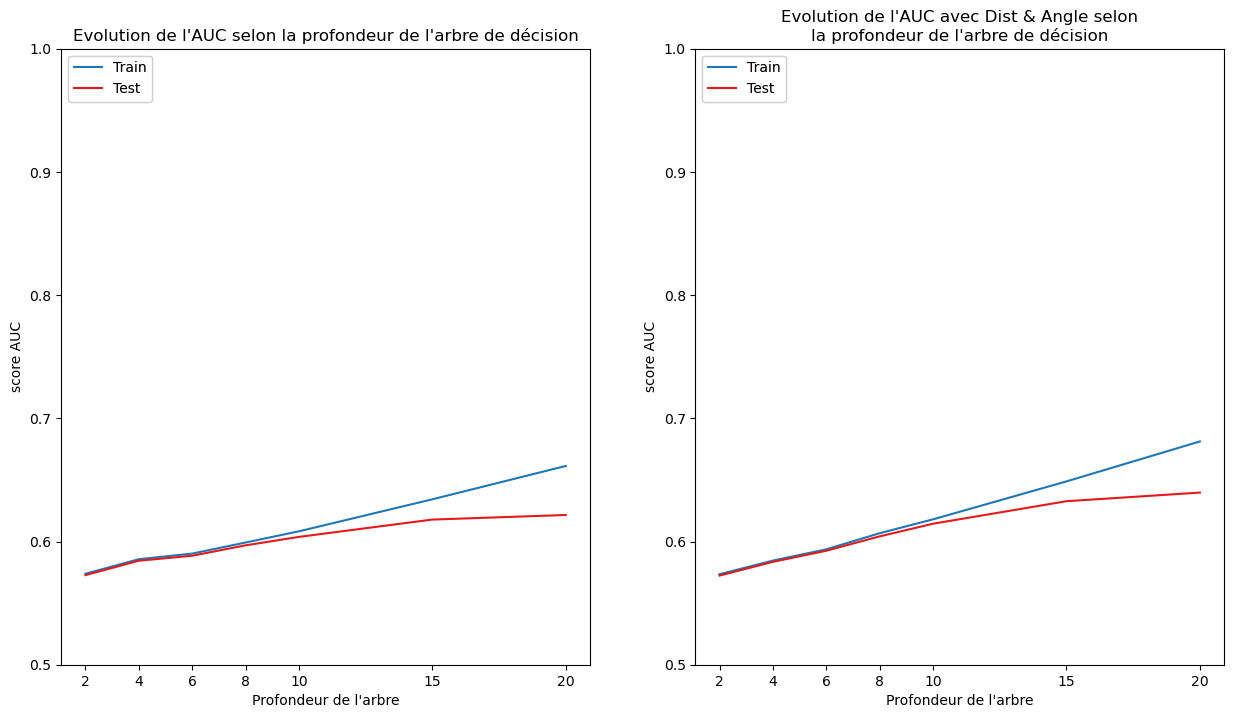

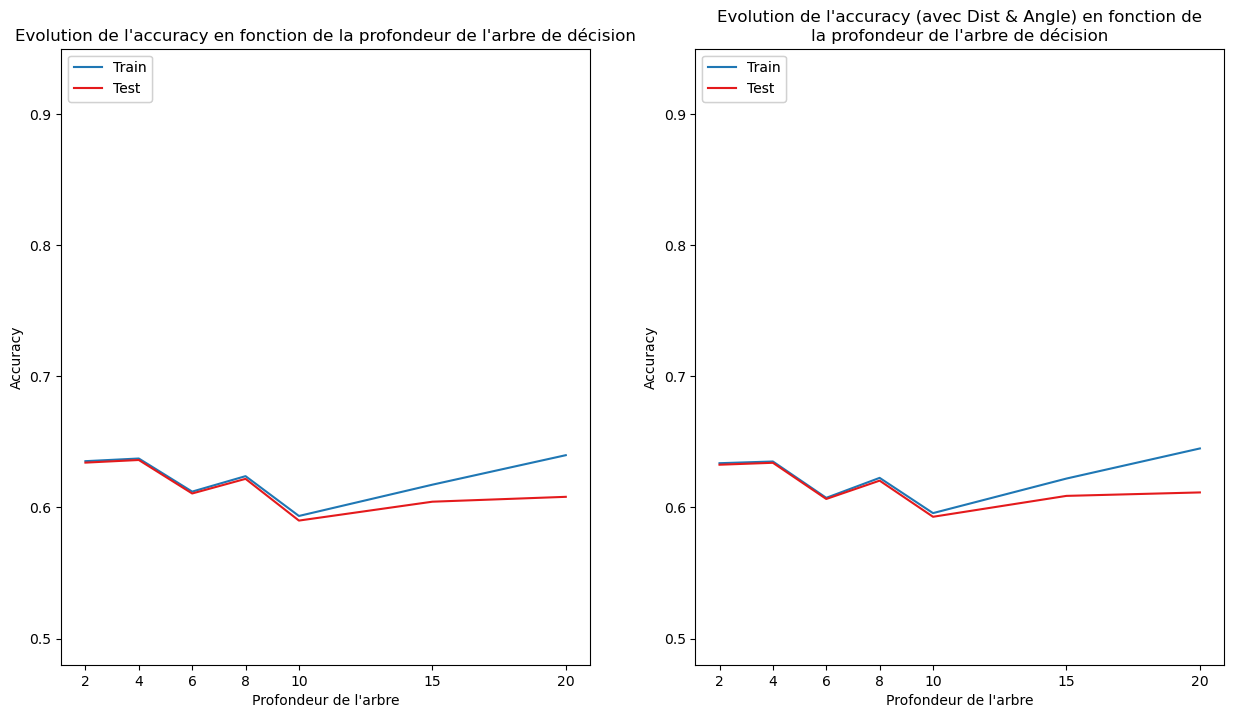

In [11]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
plots.plot(
    results_t_plus["auc_train"],
    results_t_plus["auc_test"],
    indices=depths_dtree,
    label=("Train", "Test"),
    title="Evolution de l'AUC selon la profondeur de l'arbre de décision",
    xlabel="Profondeur de l'arbre", ylabel="score AUC",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.5, figure=(fig, ax1)
)

plots.plot(
    results_dist_t_plus["auc_train"],
    results_dist_t_plus["auc_test"],
    indices=depths_dtree,
    label=("Train", "Test"),
    title="Evolution de l'AUC avec Dist & Angle selon\nla profondeur de l'arbre de décision",
    xlabel="Profondeur de l'arbre", ylabel="score AUC",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.5, figure=(fig, ax2),
)

# Saving plot
fig.savefig(f"{sess_perf_dirpath}{sess}_t-plus_auc-decisiontree")

# Showing plot
plt.show()

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_t_plus["acc_train"],
    results_t_plus["acc_test"],
    indices=depths_dtree,
    label=("Train", "Test"),
    title="Evolution de l'accuracy en fonction de la profondeur de l'arbre de décision",
    xlabel="Profondeur de l'arbre", ylabel="Accuracy",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=0.95, ybottom=0.48, figure=(fig, ax1)
)

plots.plot(
    results_dist_t_plus["acc_train"],
    results_dist_t_plus["acc_test"],
    indices=depths_dtree,
    label=("Train", "Test"),
    title="Evolution de l'accuracy (avec Dist & Angle) en fonction de\nla profondeur de l'arbre de décision",
    xlabel="Profondeur de l'arbre", ylabel="Accuracy",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=0.95, ybottom=0.48, figure=(fig, ax2),

)
# Saving plot
fig.savefig(f"{sess_perf_dirpath}{sess}_t-plus_accuracy-decisiontree")

# Showing plot
plt.show()

In [12]:
print("----- Résumé des performances en classe T plus, arbre de décision -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_t_plus["depths"]] ; print("\n")

print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_plus["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_plus["auc_test"]] ; print("\n")
print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_plus["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_plus["acc_test"]] ; print("\n")

print("---")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_plus["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_plus["auc_test"]] ; print("\n")
print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_plus["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_plus["acc_test"]] ; print()

----- Résumé des performances en classe T plus, arbre de décision -----
Profondeur          : 2     4     6     8     10    15    20    

AUC_train           : 0.57  0.59  0.59  0.60  0.61  0.63  0.66  
AUC_test            : 0.57  0.58  0.59  0.60  0.60  0.62  0.62  

Accuracy_train      : 0.64  0.64  0.61  0.62  0.59  0.62  0.64  
Accuracy_test       : 0.63  0.64  0.61  0.62  0.59  0.60  0.61  

---
AUC_train_dist      : 0.57  0.58  0.59  0.61  0.62  0.65  0.68  
AUC_test_dist       : 0.57  0.58  0.59  0.60  0.61  0.63  0.64  

Accuracy_train_dist : 0.63  0.64  0.61  0.62  0.60  0.62  0.65  
Accuracy_test_dist  : 0.63  0.63  0.61  0.62  0.59  0.61  0.61  


In [13]:
# TODO: Save auc, accuracy, mcc values to performances directory

In [14]:
# Decision Tree (CART)
dtree_plus = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=12,
    random_state=seed,
    class_weight="balanced"
)

# Decision Tree (CART) with Dist column
dtree_dist_plus = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=12,
    random_state=seed,
    class_weight="balanced"
)

In [15]:
# Fitting models on data
dtree_plus.fit(x_train, y_train)
dtree_dist_plus.fit(x_loc_train, y_loc_train)

# Prediction on train and validation
y_train_pred = dtree_plus.predict(x_train)
y_test_pred = dtree_plus.predict(x_test)

y_loc_train_pred = dtree_dist_plus.predict(x_loc_train)
y_loc_test_pred = dtree_dist_plus.predict(x_loc_test)

# Labels (for re-assignment)
labels_class = pd.Series(dtree_plus.classes_).map(
    {0: 'not_plus', 1: 'plus'}
).values

In [47]:
# ROC values - false positive rate (fpr), and true positive rate (tpr)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

fpr_loc_train, tpr_loc_train, _ = roc_curve(y_loc_train, y_loc_train_pred)
fpr_loc_test, tpr_loc_test, _ = roc_curve(y_loc_test, y_loc_test_pred)

# Model performances, how often is the classifier correct?
# train
acc_train = accuracy_score(y_train, y_train_pred)
mcc_train = matthews_corrcoef(y_train, y_train_pred)
auc_train = auc(fpr_train, tpr_train)
# test
acc_test = accuracy_score(y_test, y_test_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
auc_test = auc(fpr_test, tpr_test)

In [49]:
print("----- Arbre de décision -----")
print("Train")
print(f"{'Accuracy':<10s} = {acc_train:2.3f}")
print(f"{'AUC':<10s} = {auc_train:2.3f}")
print(f"{'MCC':<10s} = {mcc_train:2.3f}")
print()
print("Test")
print(f"{'Accuracy':<10s} = {acc_test:2.3f}")
print(f"{'AUC':<10s} = {auc_test:2.3f}")
print(f"{'MCC':<10s} = {mcc_test:2.3f}")

----- Arbre de décision -----
Train
Accuracy   = 0.607
AUC        = 0.617
MCC        = 0.209

Test
Accuracy   = 0.602
AUC        = 0.611
MCC        = 0.199


In [ ]:
# Confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
cm = confusion_matrix(y_test, y_test_pred)
cm2 = confusion_matrix(y_test, y_test_pred, normalize="true")
ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels_class,
).plot(ax=ax1, cmap="Reds")

ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels_class).plot(ax=ax2)
fig.savefig(sess_dirpath + "cd3_ki_t-plus_test-cmatrix.png")
plt.show()

In [ ]:
# print("Arbre de décision acc, Angle avec Dist")
print("Accuracy Train:", accuracy_score(y_loc_train, y_loc_train_pred))
print("AUC Train:", auc(fpr_loc_train, tpr_loc_train))
print()
print("Accuracy Test:", accuracy_score(y_loc_test, y_loc_test_pred))
print("AUC Test:", auc(fpr_loc_test, tpr_loc_test))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm_dist = confusion_matrix(y_loc_test, y_loc_test_pred)
cm2_dist = confusion_matrix(y_loc_test, y_loc_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm_dist, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2_dist, display_labels=labels_class).plot(ax=ax2)
fig.savefig(sess_dirpath + "cd3_ki_t-plus_test-dist-cmatrix.png")
plt.show()

In [ ]:
# Arbre de Décision
fig = plt.figure(figsize=(10, 30))
dot_data = tree.export_graphviz(
    dtree_plus,
    feature_names=x_columns,
    class_names=labels_class,
    filled=True
)
graph = graphviz.Source(dot_data, format="png")
graph.render(sess_dirpath + "KI_decision_tree_t-plus")
graph

In [3]:
# Arbre de décision avec l'ajout de Dist & Angle
fig = plt.figure(figsize=(10, 25))
dot_data = tree.export_graphviz(
    dtree_dist_plus,
    feature_names=x_columns_dist,
    class_names=labels_class,
    filled=True
)
graph = graphviz.Source(dot_data, format="png")
graph.render("../out/KI_decision_tree_t-plus_dist")
graph

NameError: name 'plt' is not defined

# Random Forest

In [4]:
# max_depths_rd = [2, 6, 10, 15, 20]
results_t_plus_rf = models.forest_depth_acc(
    x_train, y_train, x_test, y_test,
    depths=max_depths_rd, 
    classifier=RandomForestClassifier,
    n_estimators = 100,
    class_weight="balanced",
    n_jobs=-1
)

results_dist_t_plus_rf = models.forest_depth_acc(
    x_loc_train, y_loc_train, x_loc_test, y_loc_test,
    depths=max_depths_rd, 
    classifier=RandomForestClassifier,
    n_estimators = 100,
    class_weight="balanced",
    n_jobs=-1
)

NameError: name 'models' is not defined

In [5]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_t_plus_rf["auc_train"],
    results_t_plus_rf["auc_test"],
    indices=results_t_plus_rf["depths"],
    label=("Train AUC", "Test AUC"),
    title="T plus\nEvolution de l'AUC selon la profondeur des arbres\ndu RandomForest",
    xlabel="AUC", ylabel="Profondeur de l'arbre",
    xticks=results_t_plus_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.55, figure=(fig, ax1)
)

plots.plot(
    results_dist_t_plus_rf["auc_train"],
    results_dist_t_plus_rf["auc_test"],
    indices=results_dist_t_plus_rf["depths"],
    label=("Train AUC", "Test AUC"),
    title="T plus\nEvolution de l'AUC (avec Dist & Angle) selon la profondeur des arbres\ndu RandomForest",
    xlabel="AUC", ylabel="Profondeur de l'arbre",
    xticks=results_dist_t_plus_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.55, figure=(fig, ax2)
)

plt.show()

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_t_plus_rf["acc_train"],
    results_t_plus_rf["acc_test"],
    indices=results_t_plus_rf["depths"],
    label=("Train Accuracy", "Test Accuracy"),
    title="T plus\nEvolution de l'accuracy selon la profondeur des arbres\ndu RandomForest",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=results_t_plus_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.38, figure=(fig, ax1)
)

plots.plot(
    results_dist_t_plus_rf["acc_train"],
    results_dist_t_plus_rf["acc_test"],
    indices=results_dist_t_plus_rf["depths"],
    label=("Train Accuracy", "Test Accuracy"),
    title="T plus\nEvolution de l'Accuracy (avec Dist & Angle) selon la profondeur des arbres\ndu RandomForest",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=results_dist_t_plus_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.38, figure=(fig, ax2)
)

plt.show()

NameError: name 'plt' is not defined

In [ ]:
# print("----- Résumé des performances T plus, arbre de décision -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_t_plus_rf["depths"]] ; print("\n")
print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_plus_rf["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_plus_rf["auc_test"]] ; print("\n")

print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_plus_rf["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_plus_rf["acc_test"]] ; print("\n")

print("---")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_plus_rf["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_plus_rf["auc_test"]] ; print("\n")

print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_plus_rf["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_plus_rf["acc_test"]] ; print()

In [6]:
# RandomForest model (20, 20)
results_rf_plus = models.perform_random_forest(
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
    columns=x_columns,
    class_weight="balanced",
    scale=False
)
rf_plus = results_rf_plus["model"]

NameError: name 'models' is not defined

In [7]:
# df_mdi = pd.DataFrame(
    {
        "mean": results_rf_plus["importance_mdi"]["mean"],
        "std": results_rf_plus["importance_mdi"]["std"]
    }, index=x_columns
)

df_mdi.to_csv("KI_CD3_t-plus_importance-mdi.csv")

df_permutation = pd.DataFrame(
    {
        "mean": results_rf_plus["importance_permutation"]["mean"],
        "std": results_rf_plus["importance_permutation"]["std"]
    }, index=x_columns
)

df_permutation.to_csv("KI_CD3_t-plus_importance-permutation.csv")

NameError: name 'pd' is not defined

In [8]:
# RandomForest model with Dist & Angle columns (40, 20)
results_rf_dist_plus = models.perform_random_forest(
    x_train=x_loc_train,
    x_test=x_loc_test,
    y_train=y_loc_train,
    y_test=y_loc_test,
    columns=x_columns_dist,
    n_estimators=(10, 15, 20, 30),
    n_depths=(2, 4, 8, 10, 15),
    class_weight="balanced",
    scale=False
)
rf_dist_plus = results_rf_dist_plus["model"]

NameError: name 'models' is not defined

In [9]:
# df_mdi = pd.DataFrame(
    {
        "mean": results_rf_dist_plus["importance_mdi"]["mean"],
        "std": results_rf_dist_plus["importance_mdi"]["std"]
    }, index=x_columns_dist
)

df_mdi.to_csv("KI_CD3_t-plus-dist_importance-mdi.csv")

df_permutation = pd.DataFrame(
    {
        "mean": results_rf_dist_plus["importance_permutation"]["mean"],
        "std": results_rf_dist_plus["importance_permutation"]["std"]
    }, index=x_columns_dist
)

df_permutation.to_csv("KI_CD3_t-plus-dist_importance-permutation.csv")

NameError: name 'pd' is not defined

In [10]:
# Model Accuracy, how often is the classifier correct?
y_train_pred = rf_plus.predict(x_train)
y_test_pred = rf_plus.predict(x_test)
y_loc_train_pred = rf_dist_plus.predict(x_loc_train)
y_loc_test_pred = rf_dist_plus.predict(x_loc_test)

NameError: name 'rf_plus' is not defined

In [11]:
# labels_class = pd.Series(rf_plus.classes_).map({0: 'not_plus', 1: 'plus'}).values

NameError: name 'pd' is not defined

In [12]:
# Model Accuracy, how often is the classifier correct?
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

fpr_loc_train, tpr_loc_train, _ = roc_curve(y_loc_train, y_loc_train_pred)
fpr_loc_test, tpr_loc_test, _ = roc_curve(y_loc_test, y_loc_test_pred)

# Model Accuracy, how often is the classifier correct?
print("----- Random Forest -----")
print("Accuracy Train:", accuracy_score(y_train, y_train_pred))
print("AUC Train:", auc(fpr_train, tpr_train))
print()
print("Accuracy Test:", accuracy_score(y_test, y_test_pred))
print("AUC Test:", auc(fpr_test, tpr_test))
print()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm = confusion_matrix(y_test, y_test_pred)
cm2 = confusion_matrix(y_test, y_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels_class).plot(ax=ax2)
plt.show()

NameError: name 'roc_curve' is not defined

In [13]:
# print("Random Forest, Angle avec Dist")
print("Accuracy Train:", accuracy_score(y_loc_train, y_loc_train_pred))
print("AUC Train:", auc(fpr_loc_train, tpr_loc_train))
print()
print("Accuracy Test:", accuracy_score(y_loc_test, y_loc_test_pred))
print("AUC Test:", auc(fpr_loc_test, tpr_loc_test))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm_dist = confusion_matrix(y_loc_test, y_loc_test_pred)
cm2_dist = confusion_matrix(y_loc_test, y_loc_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm_dist, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2_dist, display_labels=labels_class).plot(ax=ax2)
plt.show()

Random Forest, Angle avec Dist


NameError: name 'accuracy_score' is not defined

# T plus & Density20 > 0

##### Jeu de données d'apprentissage et de validation (à densité20 > 0)

In [14]:
# mask_cd3_density_in = data["Density20"] > 0

NameError: name 'data' is not defined

In [15]:
# Target column
y_column = "class_t_plus"

# Define x and y dataframe
dt_xy = data[mask_cd3_density_in][[*x_columns_dist, y_column]].dropna()
X_density = dt_xy[x_columns].values  # x
X_densitY_loc = dt_xy[x_columns_dist].values  # x_loc
Y_density = dt_xy[y_column].values  # y

# Train and Validation set
X_density_train, X_density_test, Y_density_train, Y_density_test = train_test_split(
    X_density, Y_density, test_size=0.3, random_state=42, stratify=Y_density
)

# Train and Validation set (with Angle & Dist)
X_densitY_loc_train, X_densitY_loc_test, Y_densitY_loc_train, Y_densitY_loc_test = train_test_split(
    X_densitY_loc, Y_density, test_size=0.3, random_state=42, stratify=Y_density
)

NameError: name 'data' is not defined

In [16]:
# print(f"----- T plus (density20 > 0)-----")
print(f"{'Classe :':^45s}{'0':>6s}{'':2s}{'1':>6s}")
print(f"{'Comptage des classes au sein de y:':45s}{sum(Y_density == 0):>6d}{'':2s}{sum(Y_density == 1):>6d}")
print(f"{'Comptage des classes au sein de y_train:':45s}{sum(Y_density_train == 0):>6d}{'':2s}{sum(Y_density_train == 1):>6d}")
print(f"{'Comptage des classes au sein de y_test:':45s}{sum(Y_density_test == 0):>6d}{'':2s}{sum(Y_density_test == 1):>6d}")
print(f"\nNombre d'observations totales : {Y_density.shape[0]:_}")

----- T plus (density20 > 0)-----
                  Classe :                        0       1


NameError: name 'Y_density' is not defined

# Arbre de décision

In [ ]:
# depths_dtree = [2, 4, 6, 8, 10, 15, 20]

# Best number of depth
results_density_t_plus = models.forest_depth_acc(
    X_density_train, Y_density_train,
    X_density_test, Y_density_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    class_weight="balanced",
)

# Best number of depth with Dist & Angle
results_densitY_loc_t_plus = models.forest_depth_acc(
    X_densitY_loc_train, Y_densitY_loc_train,
    X_densitY_loc_test, Y_densitY_loc_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    class_weight="balanced",
)

# Performances en fonction de la profondeur

In [17]:
# Plot AUC
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
plots.plot(
    results_density_t_plus["auc_train"],
    results_density_t_plus["auc_test"],
    indices=results_density_t_plus["depths"],
    label=("Train AUC", "Test AUC"),
    title="T plus density\nEvolution de l'AUC selon la profondeur de l'arbre de décision",
    xlabel="AUC score", ylabel="Profondeur de l'arbre",
    xticks=results_density_t_plus["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.55, figure=(fig, ax1)
)

plots.plot(
    results_densitY_loc_t_plus["auc_train"],
    results_densitY_loc_t_plus["auc_test"],
    indices=results_densitY_loc_t_plus["depths"],
    label=("Train AUC", "Test AUC"),
    title="T plus density\nEvolution de l'AUC (avec Dist & Angle) selon\nla profondeur de l'arbre de décision",
    xlabel="AUC score", ylabel="Profondeur de l'arbre",
    xticks=results_densitY_loc_t_plus["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.55, figure=(fig, ax2)
)
plt.show()

# Plot accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_density_t_plus["acc_train"],
    results_density_t_plus["acc_test"],
    indices=results_density_t_plus["depths"],
    label=("Train Accuracy", "Test Accuracy"),
    title="T plus density\nEvolution de l'accuracy en fonction de la profondeur de l'arbre de décision",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=results_density_t_plus["depths"], showR2=False, showY=False,
    ytop=0.95, ybottom=0.49, figure=(fig, ax1)
)

plots.plot(
    results_densitY_loc_t_plus["acc_train"],
    results_densitY_loc_t_plus["acc_test"],
    indices=results_densitY_loc_t_plus["depths"],
    label=("Train Accuracy", "Test Accuracy"),
    title="T plus density\nEvolution de l'accuracy (avec Dist & Angle) en fonction de\nla profondeur de l'arbre de décision",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=results_densitY_loc_t_plus["depths"], showR2=False, showY=False,
    ytop=0.95, ybottom=0.49, figure=(fig, ax2)
)
plt.show()

NameError: name 'plt' is not defined

In [18]:
# print("----- Résumé des performances T plus (density20 > 0), arbre de décision -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_density_t_plus["depths"]] ; print("\n")
print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_plus["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_plus["auc_test"]] ; print("\n")

print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_plus["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_plus["acc_test"]] ; print("\n")

print("---")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_plus["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_plus["auc_test"]] ; print("\n")

print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_plus["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_plus["acc_test"]] ; print()

----- Résumé des performances T plus (density20 > 0), arbre de décision -----
Profondeur          : 

NameError: name 'results_density_t_plus' is not defined

In [ ]:
# Decision Tree (CART)
dtree_density_plus = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,
    random_state=42,
    class_weight="balanced",
)

dtree_density_plus.fit(X_density_train, Y_density_train)
y_density_train_pred = dtree_density_plus.predict(X_density_train)
y_density_test_pred = dtree_density_plus.predict(X_density_test)

# Decision Tree (CART) with Dist column
dtree_densitY_loc_plus = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,
    random_state=42,
    class_weight="balanced",
)

dtree_densitY_loc_plus.fit(X_densitY_loc_train, Y_densitY_loc_train)
y_density_loc_train_pred = dtree_densitY_loc_plus.predict(X_densitY_loc_train)
y_density_loc_test_pred = dtree_densitY_loc_plus.predict(X_densitY_loc_test)

# Performance
fpr_train, tpr_train, _ = roc_curve(Y_density_train, y_density_train_pred)
fpr_test, tpr_test, _ = roc_curve(Y_density_test, y_density_test_pred)

fpr_loc_train, tpr_loc_train, _ = roc_curve(Y_densitY_loc_train, y_density_loc_train_pred)
fpr_loc_test, tpr_loc_test, _ = roc_curve(Y_densitY_loc_test, y_density_loc_test_pred)

# Model Accuracy, how often is the classifier correct?
print("----- Arbre de décision (density20 > 0) -----")
print("Accuracy Train:", accuracy_score(Y_density_train, y_density_train_pred))
print("AUC Train:", auc(fpr_train, tpr_train))
print()
print("Accuracy Test:", accuracy_score(Y_density_test, y_density_test_pred))
print("AUC Test:", auc(fpr_test, tpr_test))
print()

In [19]:
# labels_class = pd.Series(dtree_density_plus.classes_).map({0: 'not_plus', 1: 'plus'}).values

NameError: name 'pd' is not defined

In [20]:
# Performance
fpr_train, tpr_train, _ = roc_curve(Y_density_train, y_density_train_pred)
fpr_test, tpr_test, _ = roc_curve(Y_density_test, y_density_test_pred)

fpr_loc_train, tpr_loc_train, _ = roc_curve(Y_densitY_loc_train, y_density_loc_train_pred)
fpr_loc_test, tpr_loc_test, _ = roc_curve(Y_densitY_loc_test, y_density_loc_test_pred)

# Model Accuracy, how often is the classifier correct?
print("----- Arbre de décision (density20 > 0) -----")
print("Accuracy Train:", accuracy_score(Y_density_train, y_density_train_pred))
print("AUC Train:", auc(fpr_train, tpr_train))
print()
print("Accuracy Test:", accuracy_score(Y_density_test, y_density_test_pred))
print("AUC Test:", auc(fpr_test, tpr_test))
print()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm = confusion_matrix(Y_density_test, y_density_test_pred)
cm2 = confusion_matrix(Y_density_test, y_density_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels_class).plot(ax=ax2)
plt.show()

NameError: name 'roc_curve' is not defined

In [21]:
# print("Arbre de décision acc, Angle avec Dist")
print("Accuracy Train:", accuracy_score(Y_densitY_loc_train, y_density_loc_train_pred))
print("AUC Train:", auc(fpr_loc_train, tpr_loc_train))
print()
print("Accuracy Test:", accuracy_score(Y_densitY_loc_test, y_density_loc_test_pred))
print("AUC Test:", auc(fpr_loc_test, tpr_loc_test))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm_dist = confusion_matrix(Y_densitY_loc_test, y_density_loc_test_pred)
cm2_dist = confusion_matrix(Y_densitY_loc_test, y_density_loc_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm_dist, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2_dist, display_labels=labels_class).plot(ax=ax2)
plt.show()

Arbre de décision acc, Angle avec Dist


NameError: name 'accuracy_score' is not defined

In [22]:
# Arbre de Décision
fig = plt.figure(figsize=(10, 30))
dot_data = tree.export_graphviz(
    dtree_density_plus,
    feature_names=x_columns,
    class_names=labels_class,
    filled=True
)
graph = graphviz.Source(dot_data, format="png")
#graph.render("../out/KI_decision_tree_density_t-plus_dist")
graph

NameError: name 'plt' is not defined

In [23]:
# Arbre de décision avec l'ajout de Dist & Angle
fig = plt.figure(figsize=(10, 30))
dot_data = tree.export_graphviz(
    dtree_densitY_loc_plus,
    feature_names=x_columns_dist,
    class_names=labels_class,
    filled=True
)

graph = graphviz.Source(dot_data, format="png")
#graph.render("../out/KI_decision_tree_density_t-plus_dist")
graph

NameError: name 'plt' is not defined

# Random Forest

In [24]:
# max_depths_rd = [2, 6, 10, 20, 25]
results_density_t_plus_rf = models.forest_depth_acc(
    X_density_train, Y_density_train,
    X_density_test, Y_density_test,
    depths=max_depths_rd, 
    classifier=RandomForestClassifier,
    n_estimators = 40,
    class_weight="balanced",
    n_jobs=-1
)

results_densitY_loc_t_plus_rf = models.forest_depth_acc(
    X_densitY_loc_train, Y_densitY_loc_train,
    X_densitY_loc_test, Y_densitY_loc_test,
    depths=max_depths_rd, 
    classifier=RandomForestClassifier,
    n_estimators = 20,
    class_weight="balanced",
    n_jobs=-1
)

NameError: name 'models' is not defined

In [25]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_density_t_plus_rf["auc_train"],
    results_density_t_plus_rf["auc_test"],
    indices=results_density_t_plus_rf["depths"],
    label=("Train AUC", "Test AUC"),
    title="T plus density\nEvolution de l'AUC selon la profondeur des arbres\ndu RandomForest",
    xlabel="AUC", ylabel="Profondeur de l'arbre",
    xticks=results_density_t_plus_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.55, figure=(fig, ax1)
)

plots.plot(
    results_densitY_loc_t_plus_rf["auc_train"],
    results_densitY_loc_t_plus_rf["auc_test"],
    indices=results_densitY_loc_t_plus_rf["depths"],
    label=("Train AUC", "Test AUC"),
    title="T plus density\nEvolution de l'AUC (avec Dist & Angle) selon la profondeur des arbres\ndu RandomForest",
    xlabel="AUC", ylabel="Profondeur de l'arbre",
    xticks=results_densitY_loc_t_plus_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.55, figure=(fig, ax2)
)

plt.show()

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_density_t_plus_rf["acc_train"],
    results_density_t_plus_rf["acc_test"],
    indices=results_density_t_plus_rf["depths"],
    label=("Train Accuracy", "Test Accuracy"),
    title="T plus density\nEvolution de l'accuracy selon la profondeur des arbres\ndu RandomForest",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=results_density_t_plus_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.44, figure=(fig, ax1)
)

plots.plot(
    results_densitY_loc_t_plus_rf["acc_train"],
    results_densitY_loc_t_plus_rf["acc_test"],
    indices=results_densitY_loc_t_plus_rf["depths"],
    label=("Train Accuracy", "Test Accuracy"),
    title="T plus density\nEvolution de l'Accuracy (avec Dist & Angle) selon la profondeur des arbres\ndu RandomForest",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=results_densitY_loc_t_plus_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.44, figure=(fig, ax2)
)

plt.show()

NameError: name 'plt' is not defined

In [26]:
# print("----- Résumé des performances T plus (density20 > 0), Random Forest -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_density_t_plus_rf["depths"]] ; print("\n")
print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_plus_rf["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_plus_rf["auc_test"]] ; print("\n")

print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_plus_rf["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_plus_rf["acc_test"]] ; print("\n")

print("---")

print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_plus_rf["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_plus_rf["auc_test"]] ; print("\n")

print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_plus_rf["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_plus_rf["acc_test"]] ; print()

----- Résumé des performances T plus (density20 > 0), Random Forest -----
Profondeur          : 

NameError: name 'results_density_t_plus_rf' is not defined

In [ ]:
# Random forest (30, 20)
results_density_plus = models.perform_random_forest(
    x_train=X_density_train,
    x_test=X_density_test,
    y_train=Y_density_train,
    y_test=Y_density_test,
    columns=x_columns,
    n_estimators=(10, 15, 20, 30),
    n_depths=(2, 4, 8, 10, 15),
    class_weight="balanced",
    scale=False
)

rf_density_plus = results_density_plus["model"]

In [27]:
# df_mdi = pd.DataFrame(
    {
        "mean": results_density_plus["importance_mdi"]["mean"],
        "std": results_density_plus["importance_mdi"]["std"]
    }, index=x_columns
)

df_mdi.to_csv("KI_CD3_t-plus_density_importance-mdi.csv")

df_permutation = pd.DataFrame(
    {
        "mean": results_density_plus["importance_permutation"]["mean"],
        "std": results_density_plus["importance_permutation"]["std"]
    }, index=x_columns
)

df_permutation.to_csv("KI_CD3_t-plus_density_importance-permutation.csv")

NameError: name 'pd' is not defined

In [28]:
# Random forest with Dist & Angle (20, 25)
results_densitY_loc_plus = models.perform_random_forest(
    x_train=X_densitY_loc_train,
    x_test=X_densitY_loc_test,
    y_train=Y_densitY_loc_train,
    y_test=Y_densitY_loc_test,
    columns=x_columns_dist,
    n_estimators=(10, 15, 20, 30),
    n_depths=(2, 4, 8, 10, 15),
    class_weight="balanced",
    scale=False
)

rf_densitY_loc_plus = results_densitY_loc_plus["model"]

NameError: name 'models' is not defined

In [29]:
# df_mdi = pd.DataFrame(
    {
        "mean": results_densitY_loc_plus["importance_mdi"]["mean"],
        "std": results_densitY_loc_plus["importance_mdi"]["std"]
    }, index=x_columns_dist
)

df_mdi.to_csv("KI_CD3_t-plus-dist_density_importance-mdi.csv")

df_permutation = pd.DataFrame(
    {
        "mean": results_densitY_loc_plus["importance_permutation"]["mean"],
        "std": results_densitY_loc_plus["importance_permutation"]["std"]
    }, index=x_columns_dist
)

df_permutation.to_csv("KI_CD3_t-plus-dist_density_importance-permutation.csv")

NameError: name 'pd' is not defined

In [30]:
# Model Accuracy, how often is the classifier correct?
y_density_train_pred = rf_density_plus.predict(X_density_train)
y_density_test_pred = rf_density_plus.predict(X_density_test)
y_density_loc_train_pred = rf_densitY_loc_plus.predict(X_densitY_loc_train)
y_density_loc_test_pred = rf_densitY_loc_plus.predict(X_densitY_loc_test)

# Performance
# Model Accuracy, how often is the classifier correct?
fpr_train, tpr_train, _ = roc_curve(Y_density_train, y_density_train_pred)
fpr_test, tpr_test, _ = roc_curve(Y_density_test, y_density_test_pred)

fpr_loc_train, tpr_loc_train, _ = roc_curve(Y_densitY_loc_train, y_density_loc_train_pred)
fpr_loc_test, tpr_loc_test, _ = roc_curve(Y_densitY_loc_test, y_density_loc_test_pred)

NameError: name 'rf_density_plus' is not defined

In [31]:
# labels_class = pd.Series(rf_density_plus.classes_).map({0: 'not_plus', 1: 'plus'}).values

NameError: name 'pd' is not defined

In [32]:
# print("----- Random Forest -----")
print("Accuracy Train:", accuracy_score(Y_density_train, y_density_train_pred))
print("AUC Train:", auc(fpr_train, tpr_train))
print()
print("Accuracy Test:", accuracy_score(Y_density_test, y_density_test_pred))
print("AUC Test:", auc(fpr_test, tpr_test))
print()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm = confusion_matrix(Y_density_test, y_density_test_pred)
cm2 = confusion_matrix(Y_density_test, y_density_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels_class).plot(ax=ax2)
plt.show()

----- Random Forest -----


NameError: name 'accuracy_score' is not defined

In [33]:
# print("Random Forest, Angle avec Dist")
print("Accuracy Train:", accuracy_score(Y_densitY_loc_train, y_density_loc_train_pred))
print("AUC Train:", auc(fpr_loc_train, tpr_loc_train))
print()
print("Accuracy Test:", accuracy_score(Y_densitY_loc_test, y_density_loc_test_pred))
print("AUC Test:", auc(fpr_loc_test, tpr_loc_test))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm_dist = confusion_matrix(Y_densitY_loc_test, y_density_loc_test_pred)
cm2_dist = confusion_matrix(Y_densitY_loc_test, y_density_loc_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm_dist, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2_dist, display_labels=labels_class).plot(ax=ax2)
plt.show()

Random Forest, Angle avec Dist


NameError: name 'accuracy_score' is not defined

# T enrichie

##### Arbre de décision

In [34]:
# Target column
y_column = "class_t_enriched"

# Define x and y dataframe
x = data.dropna()[x_columns].values
x_loc = data.dropna()[x_columns_dist].values
y = data.dropna()[y_column].values  # t plus class

# Train and Validation set
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42, stratify=y
)

# Train and Validation set & (Angle & Dist) (to validate the model)
x_loc_train, x_loc_test, y_loc_train, y_loc_test = train_test_split(
    x_loc, y, test_size=0.3, random_state=42, stratify=y
)

NameError: name 'data' is not defined

In [35]:
# print(f"----- T enrichie -----")
print(f"{'Classe :':^45s}{'0':>6s}{'':2s}{'1':>6s}")
print(f"{'Comptage des classes au sein de y:':45s}{sum(y == 0):>6d}{'':2s}{sum(y == 1):>6d}")
print(f"{'Comptage des classes au sein de y_train:':45s}{sum(y_train == 0):>6d}{'':2s}{sum(y_train == 1):>6d}")
print(f"{'Comptage des classes au sein de y_test:':45s}{sum(y_test == 0):>6d}{'':2s}{sum(y_test == 1):>6d}")
print(f"\nNombre d'observations totales : {y.shape[0]:_}")

----- T enrichie -----
                  Classe :                        0       1


NameError: name 'Y' is not defined

In [36]:
# depths_dtree = [2, 4, 6, 8, 10, 15, 20]

# Best number of depth
results_t_enriched = models.forest_depth_acc(
    x_train, y_train, x_test, y_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    class_weight="balanced"
)

# Best number of depth with Dist & Angle
results_dist_t_enriched = models.forest_depth_acc(
    x_loc_train, y_loc_train, x_loc_test, y_loc_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    class_weight="balanced"
)

NameError: name 'models' is not defined

In [37]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
plots.plot(
    results_t_enriched["auc_train"],
    results_t_enriched["auc_test"],
    indices=depths_dtree,
    label=("Train AUC", "Test AUC"),
    title="T enrichie\nEvolution de l'AUC selon la profondeur de l'arbre de décision",
    xlabel="AUC score", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.5, figure=(fig, ax1)
)

plots.plot(
    results_dist_t_enriched["auc_train"],
    results_dist_t_enriched["auc_test"],
    indices=depths_dtree,
    label=("Train AUC", "Test AUC"),
    title="T enrichie\nEvolution de l'AUC (avec Dist & Angle) selon\nla profondeur de l'arbre de décision",
    xlabel="AUC score", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.5, figure=(fig, ax2)
)
plt.show()

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_t_enriched["acc_train"],
    results_t_enriched["acc_test"],
    indices=depths_dtree,
    label=("Train Accuracy", "Test Accuracy"),
    title="T enrichie\nEvolution de l'accuracy en fonction de la profondeur de l'arbre de décision",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.5, figure=(fig, ax1)
)

plots.plot(
    results_dist_t_enriched["acc_train"],
    results_dist_t_enriched["acc_test"],
    indices=depths_dtree,
    label=("Train Accuracy", "Test Accuracy"),
    title="T enrichie\nEvolution de l'accuracy (avec Dist & Angle) en fonction de\nla profondeur de l'arbre de décision",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.5, figure=(fig, ax2)
)

plt.show()

NameError: name 'plt' is not defined

In [38]:
# print("----- Résumé des performances T enrichie, arbre de décision -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_t_enriched["depths"]] ; print("\n")
print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enriched["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enriched["auc_test"]] ; print("\n")

print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enriched["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enriched["acc_test"]] ; print("\n")

print("---")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_enriched["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_enriched["auc_test"]] ; print("\n")

print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_enriched["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_enriched["acc_test"]] ; print()

----- Résumé des performances T enrichie, arbre de décision -----
Profondeur          : 

NameError: name 'results_t_enriched' is not defined

In [39]:
# Decision Tree (CART)
dtree_enriched = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,
    random_state=42,
    class_weight="balanced"
)

dtree_enriched.fit(x_train, y_train)
y_train_pred = dtree_enriched.predict(x_train)
y_test_pred = dtree_enriched.predict(x_test)

# Decision Tree (CART) with Dist column
dtree_dist_enriched = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,
    random_state=42,
    class_weight="balanced"
)

dtree_dist_enriched.fit(x_loc_train, y_loc_train)
y_loc_train_pred = dtree_dist_enriched.predict(x_loc_train)
y_loc_test_pred = dtree_dist_enriched.predict(x_loc_test)
dtree_dist_enriched

NameError: name 'DecisionTreeClassifier' is not defined

In [40]:
# fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

fpr_loc_train, tpr_loc_train, _ = roc_curve(y_loc_train, y_loc_train_pred)
fpr_loc_test, tpr_loc_test, _ = roc_curve(y_loc_test, y_loc_test_pred)

NameError: name 'roc_curve' is not defined

In [41]:
# labels_class = pd.Series(dtree_enriched.classes_).map({0: 'not_enriched', 1: 'enriched'}).values

NameError: name 'pd' is not defined

In [42]:
# print("----- Arbre de décision -----")
print("Accuracy Train:", accuracy_score(y_train, y_train_pred))
print("AUC Train:", auc(fpr_train, tpr_train))
print()
print("Accuracy Test:", accuracy_score(y_test, y_test_pred))
print("AUC Test:", auc(fpr_test, tpr_test))
print()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm = confusion_matrix(y_test, y_test_pred)
cm2 = confusion_matrix(y_test, y_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels_class).plot(ax=ax2)
plt.show()

----- Arbre de décision -----


NameError: name 'accuracy_score' is not defined

In [43]:
# print("Arbre de décision, Angle avec Dist")
print("Accuracy Train:", accuracy_score(y_loc_train, y_loc_train_pred))
print("AUC Train:", auc(fpr_loc_train, tpr_loc_train))
print()
print("Accuracy Test:", accuracy_score(y_loc_test, y_loc_test_pred))
print("AUC Test:", auc(fpr_loc_test, tpr_loc_test))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm_dist = confusion_matrix(y_loc_test, y_loc_test_pred)
cm2_dist = confusion_matrix(y_loc_test, y_loc_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm_dist, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2_dist, display_labels=labels_class).plot(ax=ax2)
plt.show()

Arbre de décision, Angle avec Dist


NameError: name 'accuracy_score' is not defined

In [44]:
# Arbre de Décision
fig = plt.figure(figsize=(10, 30))
dot_data = tree.export_graphviz(
    dtree_enriched,
    feature_names=x_columns,
    class_names=labels_class,
    filled=True
)
graph = graphviz.Source(dot_data, format="png")
#graph.render("../out/KI_decision_tree_t-enriched")
graph

NameError: name 'plt' is not defined

In [45]:
# Arbre de décision avec l'ajout de Dist & Angle
fig = plt.figure(figsize=(10, 30))
dot_data = tree.export_graphviz(
    dtree_dist_enriched,
    feature_names=x_columns_dist,
    class_names=labels_class,
    filled=True
)
graph = graphviz.Source(dot_data, format="png")
#graph.render("../out/KI_decision_tree_t-enriched_dist")
graph

NameError: name 'plt' is not defined

# Random Forest


In [46]:
# max_depths_rd = [2, 4, 6, 8, 10, 15, 20]
results_t_enriched_rf = models.forest_depth_acc(
    x_train, y_train, x_test, y_test,
    depths=max_depths_rd, 
    classifier=RandomForestClassifier,
    n_estimators = 100,
    class_weight="balanced",
    n_jobs=-1
)

results_dist_t_enriched_rf = models.forest_depth_acc(
    x_loc_train, y_loc_train, x_loc_test, y_loc_test,
    depths=max_depths_rd, 
    classifier=RandomForestClassifier,
    n_estimators = 100,
    class_weight="balanced",
    n_jobs=-1
)

NameError: name 'models' is not defined

In [47]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_t_enriched_rf["auc_train"],
    results_t_enriched_rf["auc_test"],
    indices=results_t_enriched_rf["depths"],
    label=("Train AUC", "Test AUC"),
    title="T enrichie\nEvolution de l'AUC selon la profondeur des arbres du RandomForest",
    xlabel="AUC", ylabel="Profondeur de l'arbre",
    xticks=results_t_enriched_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.58, figure=(fig, ax1)
)

plots.plot(
    results_dist_t_enriched_rf["auc_train"],
    results_dist_t_enriched_rf["auc_test"],
    indices=results_dist_t_enriched_rf["depths"],
    label=("Train AUC", "Test AUC"),
    title="T enrichie\nEvolution de l'AUC (avec Dist & Angle)\n selon la profondeur des arbres du RandomForest",
    xlabel="AUC", ylabel="Profondeur de l'arbre",
    xticks=results_dist_t_enriched_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.58, figure=(fig, ax2)
)

plt.show()

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_t_enriched_rf["acc_train"],
    results_t_enriched_rf["acc_test"],
    indices=results_t_enriched_rf["depths"],
    label=("Train Accuracy", "Test Accuracy"),
    title="T enrichie\nEvolution de l'accuracy selon la profondeur des arbres du RandomForest",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=results_t_enriched_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.58, figure=(fig, ax1)
)

plots.plot(
    results_dist_t_enriched_rf["acc_train"],
    results_dist_t_enriched_rf["acc_test"],
    indices=results_dist_t_enriched_rf["depths"],
    label=("Train Accuracy", "Test Accuracy"),
    title="T enrichie\nEvolution de l'Accuracy (avec Dist & Angle)\n selon la profondeur des arbres du RandomForest",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=results_dist_t_enriched_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.58, figure=(fig, ax2)
)

plt.show()

NameError: name 'plt' is not defined

In [ ]:
# print("----- Résumé des performances T enrichie, arbre de décision -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_t_enriched_rf["depths"]] ; print("\n")
print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enriched_rf["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enriched_rf["auc_test"]] ; print("\n")

print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enriched_rf["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enriched_rf["acc_test"]] ; print("\n")

print("---")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_enriched_rf["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_enriched_rf["auc_test"]] ; print("\n")

print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_enriched_rf["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_enriched_rf["acc_test"]] ; print()

In [48]:
# RandomForest model
results_enriched = models.perform_random_forest(
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
    columns=x_columns,
    n_estimators=(10, 15, 20, 30),
    n_depths=(2, 4, 8, 10, 15),
    class_weight="balanced",
    scale=False
)

rf_enriched = results_enriched["model"]

NameError: name 'models' is not defined

In [49]:
# df_mdi = pd.DataFrame(
    {
        "mean": results_enriched["importance_mdi"]["mean"],
        "std": results_enriched["importance_mdi"]["std"]
    }, index=x_columns
)

df_mdi.to_csv("KI_CD3_enriched_importance-mdi.csv")

df_permutation = pd.DataFrame(
    {
        "mean": results_enriched["importance_permutation"]["mean"],
        "std": results_enriched["importance_permutation"]["std"]
    }, index=x_columns
)

df_permutation.to_csv("KI_CD3_enriched_importance-permutation.csv")

NameError: name 'pd' is not defined

In [50]:
# RandomForest model with Dist & Angle columns
results_dist_enriched = models.perform_random_forest(
    x_train=x_loc_train,
    x_test=x_loc_test,
    y_train=y_loc_train,
    y_test=y_loc_test,
    columns=x_columns_dist,
    n_estimators=(10, 15, 20, 30),
    n_depths=(2, 4, 8, 10, 15),
    class_weight="balanced",
    scale=False
)

rf_dist_enriched = results_dist_enriched["model"]

NameError: name 'models' is not defined

In [51]:
# df_mdi = pd.DataFrame(
    {
        "mean": results_dist_enriched["importance_mdi"]["mean"],
        "std": results_dist_enriched["importance_mdi"]["std"]
    }, index=x_columns_dist
)

df_mdi.to_csv("KI_CD3_enriched-dist_importance-mdi.csv")

df_permutation = pd.DataFrame(
    {
        "mean": results_dist_enriched["importance_permutation"]["mean"],
        "std": results_dist_enriched["importance_permutation"]["std"]
    }, index=x_columns_dist
)

df_permutation.to_csv("KI_CD3_enriched-dist_importance-permutation.csv")

NameError: name 'pd' is not defined

In [72]:
# Model Accuracy, how often is the classifier correct?
y_train_pred = rf_enriched.predict(x_train)
y_test_pred = rf_enriched.predict(x_test)
y_loc_train_pred = rf_dist_enriched.predict(x_loc_train)
y_loc_test_pred = rf_dist_enriched.predict(x_loc_test)

In [52]:
# fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

fpr_loc_train, tpr_loc_train, _ = roc_curve(y_loc_train, y_loc_train_pred)
fpr_loc_test, tpr_loc_test, _ = roc_curve(y_loc_test, y_loc_test_pred)

NameError: name 'roc_curve' is not defined

In [53]:
# labels_class = pd.Series(rf_enriched.classes_).map({0: 'not_enriched', 1: 'enriched'}).values

NameError: name 'pd' is not defined

In [54]:
# print("----- Random Forest -----")
print("Accuracy Train:", accuracy_score(y_train, y_train_pred))
print("AUC Train:", auc(fpr_train, tpr_train))
print()
print("Accuracy Test:", accuracy_score(y_test, y_test_pred))
print("AUC Test:", auc(fpr_test, tpr_test))
print()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm = confusion_matrix(y_test, y_test_pred)
cm2 = confusion_matrix(y_test, y_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels_class).plot(ax=ax2)
plt.show()

----- Random Forest -----


NameError: name 'accuracy_score' is not defined

In [55]:
# print("Random Forest, Angle avec Dist")
print("Accuracy Train:", accuracy_score(y_loc_train, y_loc_train_pred))
print("AUC Train:", auc(fpr_loc_train, tpr_loc_train))
print()
print("Accuracy Test:", accuracy_score(y_loc_test, y_loc_test_pred))
print("AUC Test:", auc(fpr_loc_test, tpr_loc_test))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm_dist = confusion_matrix(y_loc_test, y_loc_test_pred)
cm2_dist = confusion_matrix(y_loc_test, y_loc_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm_dist, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2_dist, display_labels=labels_class).plot(ax=ax2)
plt.show()

Random Forest, Angle avec Dist


NameError: name 'accuracy_score' is not defined

# T enrichie & Density20 > 0

##### Jeu de données d'apprentissage et de validation (à densité20 > 0)

In [56]:
# Target column
y_column = "class_t_enriched"

# Define x and y dataframe
dt_xy = data[mask_cd3_density_in][[*x_columns_dist, y_column]].dropna()
X_density = dt_xy[x_columns].values  # x
X_densitY_loc = dt_xy[x_columns_dist].values  # x_loc
Y_density = dt_xy[y_column].values  # y

# Train and Validation set
X_density_train, X_density_test, Y_density_train, Y_density_test = train_test_split(
    X_density, Y_density, test_size=0.3, random_state=42, stratify=Y_density
)

# Train and Validation set (with Angle & Dist)
X_densitY_loc_train, X_densitY_loc_test, Y_densitY_loc_train, Y_densitY_loc_test = train_test_split(
    X_densitY_loc, Y_density, test_size=0.3, random_state=42, stratify=Y_density
)

NameError: name 'data' is not defined

In [57]:
# print(f"----- T enrichie (density20 > 0)-----")
print(f"{'Classe :':^45s}{'0':>6s}{'':2s}{'1':>6s}")
print(f"{'Comptage des classes au sein de y:':45s}{sum(Y_density == 0):>6d}{'':2s}{sum(Y_density == 1):>6d}")
print(f"{'Comptage des classes au sein de y_train:':45s}{sum(Y_density_train == 0):>6d}{'':2s}{sum(Y_density_train == 1):>6d}")
print(f"{'Comptage des classes au sein de y_test:':45s}{sum(Y_density_test == 0):>6d}{'':2s}{sum(Y_density_test == 1):>6d}")
print(f"\nNombre d'observations totales : {Y_density.shape[0]:_}")

----- T enrichie (density20 > 0)-----
                  Classe :                        0       1


NameError: name 'Y_density' is not defined

# Arbre de décision

In [58]:
# depths_dtree = [2, 4, 6, 8, 10, 15, 20]

# Best number of depth
results_density_t_enriched = models.forest_depth_acc(
    X_density_train, Y_density_train,
    X_density_test, Y_density_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    class_weight="balanced",
)

# Best number of depth with Dist & Angle
results_densitY_loc_t_enriched = models.forest_depth_acc(
    X_densitY_loc_train, Y_densitY_loc_train,
    X_densitY_loc_test, Y_densitY_loc_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    class_weight="balanced",
)

NameError: name 'models' is not defined

In [59]:
# Plot AUC
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
plots.plot(
    results_density_t_enriched["auc_train"],
    results_density_t_enriched["auc_test"],
    indices=depths_dtree,
    label=("Train AUC", "Test AUC"),
    title="T enriched density\nEvolution de l'AUC selon la profondeur de l'arbre de décision",
    xlabel="AUC score", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.54, figure=(fig, ax1)
)

plots.plot(
    results_densitY_loc_t_enriched["auc_train"],
    results_densitY_loc_t_enriched["auc_test"],
    indices=depths_dtree,
    label=("Train AUC", "Test AUC"),
    title="T enriched density\nEvolution de l'AUC (avec Dist & Angle) selon\nla profondeur de l'arbre de décision",
    xlabel="AUC score", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.54, figure=(fig, ax2)
)
plt.show()

# Plot accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_density_t_enriched["acc_train"],
    results_density_t_enriched["acc_test"],
    indices=depths_dtree,
    label=("Train Accuracy", "Test Accuracy"),
    title="T enriched density\nEvolution de l'accuracy en fonction de la profondeur de l'arbre de décision",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.54, figure=(fig, ax1)
)

plots.plot(
    results_densitY_loc_t_enriched["acc_train"],
    results_densitY_loc_t_enriched["acc_test"],
    indices=depths_dtree,
    label=("Train Accuracy", "Test Accuracy"),
    title="T enriched density\nEvolution de l'accuracy (avec Dist & Angle) en fonction de\nla profondeur de l'arbre de décision",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.54, figure=(fig, ax2)
)
plt.show()

NameError: name 'plt' is not defined

In [60]:
# print("----- Résumé des performances T plus (density20 > 0), arbre de décision -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_density_t_enriched["depths"]] ; print("\n")
print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_enriched["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_enriched["auc_test"]] ; print("\n")

print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_enriched["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_enriched["acc_test"]] ; print("\n")

print("---")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_enriched["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_enriched["auc_test"]] ; print("\n")

print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_enriched["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_enriched["acc_test"]] ; print()

----- Résumé des performances T plus (density20 > 0), arbre de décision -----
Profondeur          : 

NameError: name 'results_density_t_enriched' is not defined

In [ ]:
# Decision Tree (CART)
dtree_density_enriched = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,
    random_state=42,
    class_weight="balanced",
)

dtree_density_enriched.fit(X_density_train, Y_density_train)
y_density_train_pred = dtree_density_enriched.predict(X_density_train)
y_density_test_pred = dtree_density_enriched.predict(X_density_test)

# Decision Tree (CART) with Dist column
dtree_densitY_loc_enriched = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,
    random_state=42,
    class_weight="balanced",
)

dtree_densitY_loc_enriched.fit(X_densitY_loc_train, Y_densitY_loc_train)
y_density_loc_train_pred = dtree_densitY_loc_enriched.predict(X_densitY_loc_train)
y_density_loc_test_pred = dtree_densitY_loc_enriched.predict(X_densitY_loc_test)

# Performance
fpr_train, tpr_train, _ = roc_curve(Y_density_train, y_density_train_pred)
fpr_test, tpr_test, _ = roc_curve(Y_density_test, y_density_test_pred)

fpr_loc_train, tpr_loc_train, _ = roc_curve(Y_densitY_loc_train, y_density_loc_train_pred)
fpr_loc_test, tpr_loc_test, _ = roc_curve(Y_densitY_loc_test, y_density_loc_test_pred)

In [61]:
# labels_class = pd.Series(dtree_density_enriched.classes_).map({0: 'not_enriched', 1: 'enriched'}).values

NameError: name 'pd' is not defined

In [62]:
# Model Accuracy, how often is the classifier correct?
print("----- Arbre de décision (density20 > 0) -----")
print("Accuracy Train:", accuracy_score(Y_density_train, y_density_train_pred))
print("AUC Train:", auc(fpr_train, tpr_train))
print()
print("Accuracy Test:", accuracy_score(Y_density_test, y_density_test_pred))
print("AUC Test:", auc(fpr_test, tpr_test))
print()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm = confusion_matrix(Y_density_test, y_density_test_pred)
cm2 = confusion_matrix(Y_density_test, y_density_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels_class).plot(ax=ax2)
plt.show()

----- Arbre de décision (density20 > 0) -----


NameError: name 'accuracy_score' is not defined

In [63]:
# print("Arbre de décision acc, Angle avec Dist")
print("Accuracy Train:", accuracy_score(Y_densitY_loc_train, y_density_loc_train_pred))
print("AUC Train:", auc(fpr_loc_train, tpr_loc_train))
print()
print("Accuracy Test:", accuracy_score(Y_densitY_loc_test, y_density_loc_test_pred))
print("AUC Test:", auc(fpr_loc_test, tpr_loc_test))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm_dist = confusion_matrix(Y_densitY_loc_train, y_density_loc_train_pred)
cm2_dist = confusion_matrix(Y_densitY_loc_train, y_density_loc_train_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm_dist, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2_dist, display_labels=labels_class).plot(ax=ax2)
plt.show()

Arbre de décision acc, Angle avec Dist


NameError: name 'accuracy_score' is not defined

In [64]:
# Arbre de Décision
fig = plt.figure(figsize=(10, 30))
dot_data = tree.export_graphviz(
    dtree_density_enriched,
    feature_names=x_columns,
    class_names=labels_class,
    filled=True
)
graph = graphviz.Source(dot_data, format="png")
#graph.render("../out/KI_decision_tree_density_t-plus_dist")
graph

NameError: name 'plt' is not defined

In [65]:
# Arbre de décision avec l'ajout de Dist & Angle
fig = plt.figure(figsize=(10, 30))
dot_data = tree.export_graphviz(
    dtree_densitY_loc_enriched,
    feature_names=x_columns_dist,
    class_names=labels_class,
    filled=True
)

graph = graphviz.Source(dot_data, format="png")
graph.render("../out/KI_decision_tree_density_t-plus_dist")
graph

NameError: name 'plt' is not defined

# Random Forest

In [66]:
# max_depths_rd = [2, 6, 10, 15, 20]
results_density_t_enriched_rf = models.forest_depth_acc(
    X_density_train, Y_density_train,
    X_density_test, Y_density_test,
    depths=max_depths_rd, 
    classifier=RandomForestClassifier,
    n_estimators = 100,
    class_weight="balanced",
    n_jobs=-1
)

results_densitY_loc_t_enriched_rf = models.forest_depth_acc(
    X_densitY_loc_train, Y_densitY_loc_train,
    X_densitY_loc_test, Y_densitY_loc_test,
    depths=max_depths_rd, 
    classifier=RandomForestClassifier,
    n_estimators = 100,
    class_weight="balanced",
    n_jobs=-1
)

NameError: name 'models' is not defined

In [67]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_density_t_enriched_rf["auc_train"],
    results_density_t_enriched_rf["auc_test"],
    indices=results_density_t_enriched_rf["depths"],
    label=("Train AUC", "Test AUC"),
    title="T enriched density\nEvolution de l'AUC selon la profondeur des arbres\ndu RandomForest",
    xlabel="AUC", ylabel="Profondeur de l'arbre",
    xticks=results_density_t_enriched_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.58, figure=(fig, ax1)
)

plots.plot(
    results_densitY_loc_t_enriched_rf["auc_train"],
    results_densitY_loc_t_enriched_rf["auc_test"],
    indices=results_densitY_loc_t_enriched_rf["depths"],
    label=("Train AUC", "Test AUC"),
    title="T enriched density\nEvolution de l'AUC (avec Dist & Angle) selon la profondeur des arbres\ndu RandomForest",
    xlabel="AUC", ylabel="Profondeur de l'arbre",
    xticks=results_densitY_loc_t_enriched_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.58, figure=(fig, ax2)
)

plt.show()

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_density_t_enriched_rf["acc_train"],
    results_density_t_enriched_rf["acc_test"],
    indices=results_density_t_enriched_rf["depths"],
    label=("Train Accuracy", "Test Accuracy"),
    title="T enriched density\nEvolution de l'accuracy selon la profondeur des arbres\ndu RandomForest",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=results_density_t_enriched_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.58, figure=(fig, ax1)
)

plots.plot(
    results_densitY_loc_t_enriched_rf["acc_train"],
    results_densitY_loc_t_enriched_rf["acc_test"],
    indices=results_densitY_loc_t_enriched_rf["depths"],
    label=("Train Accuracy", "Test Accuracy"),
    title="T enriched density\nEvolution de l'Accuracy (avec Dist & Angle) selon la profondeur des arbres\ndu RandomForest",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=results_densitY_loc_t_enriched_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.58, figure=(fig, ax2)
)

plt.show()

NameError: name 'plt' is not defined

In [ ]:
# print("----- Résumé des performances T enrichie (density20 > 0), Random Forest -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_density_t_enriched_rf["depths"]] ; print("\n")
print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_enriched_rf["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_enriched_rf["auc_test"]] ; print("\n")

print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_enriched_rf["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_enriched_rf["acc_test"]] ; print("\n")

print("---")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_enriched_rf["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_enriched_rf["auc_test"]] ; print("\n")

print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_enriched_rf["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_enriched_rf["acc_test"]] ; print()

In [68]:
# Random forest
results_density_enriched = models.perform_random_forest(
    x_train=X_density_train,
    x_test=X_density_test,
    y_train=Y_density_train,
    y_test=Y_density_test,
    columns=x_columns,
    n_estimators=(10, 15, 20, 30),
    n_depths=(2, 4, 8, 10, 15),
    class_weight="balanced",
    scale=False
)

rf_density_enriched = results_density_enriched["model"]

NameError: name 'models' is not defined

In [69]:
# df_mdi = pd.DataFrame(
    {
        "mean": results_density_enriched["importance_mdi"]["mean"],
        "std": results_density_enriched["importance_mdi"]["std"]
    }, index=x_columns
)

df_mdi.to_csv("KI_CD3_enriched_density_importance-mdi.csv")

df_permutation = pd.DataFrame(
    {
        "mean": results_density_enriched["importance_permutation"]["mean"],
        "std": results_density_enriched["importance_permutation"]["std"]
    }, index=x_columns
)

df_permutation.to_csv("KI_CD3_enriched_density_importance-permutation.csv")

NameError: name 'pd' is not defined

In [70]:
# Random forest with Dist & Angle
results_densitY_loc_enriched = models.perform_random_forest(
    x_train=X_densitY_loc_train,
    x_test=X_densitY_loc_test,
    y_train=Y_densitY_loc_train,
    y_test=Y_densitY_loc_test,
    columns=x_columns_dist,
    n_estimators=(10, 15, 20, 30),
    n_depths=(2, 4, 8, 10, 15),
    class_weight="balanced",
    scale=False
)

rf_densitY_loc_enriched = results_densitY_loc_enriched["model"]

NameError: name 'models' is not defined

In [71]:
# df_mdi = pd.DataFrame(
    {
        "mean": results_densitY_loc_enriched["importance_mdi"]["mean"],
        "std": results_densitY_loc_enriched["importance_mdi"]["std"]
    }, index=x_columns_dist
)

df_mdi.to_csv("KI_CD3_enriched-dist_density_importance-mdi.csv")

df_permutation = pd.DataFrame(
    {
        "mean": results_densitY_loc_enriched["importance_permutation"]["mean"],
        "std": results_densitY_loc_enriched["importance_permutation"]["std"]
    }, index=x_columns_dist
)

df_permutation.to_csv("KI_CD3_enriched-dist_density_importance-permutation.csv")

NameError: name 'pd' is not defined

In [72]:
# Model Accuracy, how often is the classifier correct?
y_density_train_pred = rf_density_enriched.predict(X_density_train)
y_density_test_pred = rf_density_enriched.predict(X_density_test)
y_density_loc_train_pred = rf_densitY_loc_enriched.predict(X_densitY_loc_train)
y_density_loc_test_pred = rf_densitY_loc_enriched.predict(X_densitY_loc_test)

# Performance
# Model Accuracy, how often is the classifier correct?
fpr_train, tpr_train, _ = roc_curve(Y_density_train, y_density_train_pred)
fpr_test, tpr_test, _ = roc_curve(Y_density_test, y_density_test_pred)

fpr_loc_train, tpr_loc_train, _ = roc_curve(Y_densitY_loc_train, y_density_loc_train_pred)
fpr_loc_test, tpr_loc_test, _ = roc_curve(Y_densitY_loc_test, y_density_loc_test_pred)

# Model Accuracy, how often is the classifier correct?
print("----- Random Forest (density20 > 0) -----")
print("Accuracy Train:", accuracy_score(Y_density_train, y_density_train_pred))
print("AUC Train:", auc(fpr_train, tpr_train))
print()
print("Accuracy Test:", accuracy_score(Y_density_test, y_density_test_pred))
print("AUC Test:", auc(fpr_test, tpr_test))
print()

print("Random Forest, Angle avec Dist")
print("Accuracy Train:", accuracy_score(Y_densitY_loc_train, y_density_loc_train_pred))
print("AUC Train:", auc(fpr_loc_train, tpr_loc_train))
print()
print("Accuracy Test:", accuracy_score(Y_densitY_loc_test, y_density_loc_test_pred))
print("AUC Test:", auc(fpr_loc_test, tpr_loc_test))

NameError: name 'rf_density_enriched' is not defined

In [73]:
# labels_class = pd.Series(rf_density_enriched.classes_).map({0: 'not_enriched', 1: 'enriched'}).values

NameError: name 'pd' is not defined

In [74]:
# print("----- Random Forest (density20 > 0) -----")
print("Accuracy Train:", accuracy_score(Y_density_train, y_density_train_pred))
print("AUC Train:", auc(fpr_train, tpr_train))
print()
print("Accuracy Test:", accuracy_score(Y_density_test, y_density_test_pred))
print("AUC Test:", auc(fpr_test, tpr_test))
print()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm = confusion_matrix(Y_density_test, y_density_test_pred)
cm2 = confusion_matrix(Y_density_test, y_density_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels_class).plot(ax=ax2)
plt.show()

----- Random Forest (density20 > 0) -----


NameError: name 'accuracy_score' is not defined

In [75]:
# print("Random Forest, Angle avec Dist")
print("Accuracy Train:", accuracy_score(Y_densitY_loc_train, y_density_loc_train_pred))
print("AUC Train:", auc(fpr_loc_train, tpr_loc_train))
print()
print("Accuracy Test:", accuracy_score(Y_densitY_loc_test, y_density_loc_test_pred))
print("AUC Test:", auc(fpr_loc_test, tpr_loc_test))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm_dist = confusion_matrix(Y_densitY_loc_test, y_density_loc_test_pred)
cm2_dist = confusion_matrix(Y_densitY_loc_test, y_density_loc_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm_dist, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2_dist, display_labels=labels_class).plot(ax=ax2)
plt.show()

Random Forest, Angle avec Dist


NameError: name 'accuracy_score' is not defined

# T enrichie 2

##### Arbre de décision

In [76]:
# Target column
y_column = "class_t_enriched_2"

# Define x and y dataframe
x = data.dropna()[x_columns].values
x_loc = data.dropna()[x_columns_dist].values
y = data.dropna()[y_column].values  # t plus class

# Train and Validation set
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42, stratify=y
)

# Train and Validation set & (Angle & Dist) (to validate the model)
x_loc_train, x_loc_test, y_loc_train, y_loc_test = train_test_split(
    x_loc, y, test_size=0.3, random_state=42, stratify=y
)

NameError: name 'data' is not defined

In [77]:
# print(f"----- T enrichie 2 -----")
print(f"{'Classe :':^45s}{'0':>6s}{'':2s}{'1':>6s}")
print(f"{'Comptage des classes au sein de y:':45s}{sum(y == 0):>6d}{'':2s}{sum(y == 1):>6d}")
print(f"{'Comptage des classes au sein de y_train:':45s}{sum(y_train == 0):>6d}{'':2s}{sum(y_train == 1):>6d}")
print(f"{'Comptage des classes au sein de y_test:':45s}{sum(y_test == 0):>6d}{'':2s}{sum(y_test == 1):>6d}")
print(f"\nNombre d'observations totales : {y.shape[0]:_}")

----- T enrichie 2 -----
                  Classe :                        0       1


NameError: name 'Y' is not defined

In [78]:
# depths_dtree = [2, 4, 6, 8, 10, 15, 20]

# Best number of depth
results_t_enriched_2 = models.forest_depth_acc(
    x_train, y_train, x_test, y_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    class_weight="balanced"
)

# Best number of depth with Dist & Angle
results_dist_t_enriched_2 = models.forest_depth_acc(
    x_loc_train, y_loc_train, x_loc_test, y_loc_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    class_weight="balanced"
)

NameError: name 'models' is not defined

In [79]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
plots.plot(
    results_t_enriched_2["auc_train"],
    results_t_enriched_2["auc_test"],
    indices=depths_dtree,
    label=("Train AUC", "Test AUC"),
    title="T enrichie 2\nEvolution de l'AUC selon la profondeur de l'arbre de décision",
    xlabel="AUC score", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.57, figure=(fig, ax1)
)

plots.plot(
    results_dist_t_enriched_2["auc_train"],
    results_dist_t_enriched_2["auc_test"],
    indices=depths_dtree,
    label=("Train AUC", "Test AUC"),
    title="T enrichie 2\nEvolution de l'AUC (avec Dist & Angle) selon\nla profondeur de l'arbre de décision",
    xlabel="AUC score", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.57, figure=(fig, ax2)
)
plt.show()

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_t_enriched_2["acc_train"],
    results_t_enriched_2["acc_test"],
    indices=depths_dtree,
    label=("Train Accuracy", "Test Accuracy"),
    title="T enrichie 2\nEvolution de l'accuracy en fonction de la profondeur de l'arbre de décision",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.50, figure=(fig, ax1)
)

plots.plot(
    results_dist_t_enriched_2["acc_train"],
    results_dist_t_enriched_2["acc_test"],
    indices=depths_dtree,
    label=("Train Accuracy", "Test Accuracy"),
    title="T enrichie 2\nEvolution de l'accuracy (avec Dist & Angle) en fonction de\nla profondeur de l'arbre de décision",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.50, figure=(fig, ax2)
)

plt.show()

NameError: name 'plt' is not defined

In [80]:
# print("----- Résumé des performances T enrichie 2, arbre de décision -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_t_enriched_2["depths"]] ; print("\n")
print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enriched_2["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enriched_2["auc_test"]] ; print("\n")

print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enriched_2["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enriched_2["acc_test"]] ; print("\n")

print("---")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_enriched_2["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_enriched_2["auc_test"]] ; print("\n")

print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_enriched_2["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_enriched_2["acc_test"]] ; print()

----- Résumé des performances T enrichie 2, arbre de décision -----
Profondeur          : 

NameError: name 'results_t_enriched_2' is not defined

In [81]:
# Decision Tree (CART)
dtree_enriched_2 = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,
    random_state=42,
    class_weight="balanced"
)

dtree_enriched_2.fit(x_train, y_train)
y_train_pred = dtree_enriched_2.predict(x_train)
y_test_pred = dtree_enriched_2.predict(x_test)

# Decision Tree (CART) with Dist column
dtree_dist_enriched_2 = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,
    random_state=42,
    class_weight="balanced"
)

dtree_dist_enriched_2.fit(x_loc_train, y_loc_train)
y_loc_train_pred = dtree_dist_enriched_2.predict(x_loc_train)
y_loc_test_pred = dtree_dist_enriched_2.predict(x_loc_test)
dtree_dist_enriched_2

NameError: name 'DecisionTreeClassifier' is not defined

In [82]:
# fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

fpr_loc_train, tpr_loc_train, _ = roc_curve(y_loc_train, y_loc_train_pred)
fpr_loc_test, tpr_loc_test, _ = roc_curve(y_loc_test, y_loc_test_pred)

NameError: name 'roc_curve' is not defined

In [83]:
# labels_class = pd.Series(dtree_enriched_2.classes_).map({0: 'not_enriched_2', 1: 'enriched_2'}).values

NameError: name 'pd' is not defined

In [84]:
# print("----- Arbre de décision -----")
print("Accuracy Train:", accuracy_score(y_train, y_train_pred))
print("AUC Train:", auc(fpr_train, tpr_train))
print()
print("Accuracy Test:", accuracy_score(y_test, y_test_pred))
print("AUC Test:", auc(fpr_test, tpr_test))
print()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm = confusion_matrix(y_test, y_test_pred)
cm2 = confusion_matrix(y_test, y_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels_class).plot(ax=ax2)
plt.show()

----- Arbre de décision -----


NameError: name 'accuracy_score' is not defined

In [85]:
# print("Arbre de décision, Angle avec Dist")
print("Accuracy Train:", accuracy_score(y_loc_train, y_loc_train_pred))
print("AUC Train:", auc(fpr_loc_train, tpr_loc_train))
print()
print("Accuracy Test:", accuracy_score(y_loc_test, y_loc_test_pred))
print("AUC Test:", auc(fpr_loc_test, tpr_loc_test))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm_dist = confusion_matrix(y_loc_test, y_loc_test_pred)
cm2_dist = confusion_matrix(y_loc_test, y_loc_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm_dist, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2_dist, display_labels=labels_class).plot(ax=ax2)
plt.show()

Arbre de décision, Angle avec Dist


NameError: name 'accuracy_score' is not defined

In [86]:
# Arbre de Décision
fig = plt.figure(figsize=(10, 30))
dot_data = tree.export_graphviz(
    dtree_enriched_2,
    feature_names=x_columns,
    class_names=labels_class,
    filled=True
)
graph = graphviz.Source(dot_data, format="png")
#graph.render("../out/KI_decision_tree_t-enriched_2")
graph

NameError: name 'plt' is not defined

In [87]:
# Arbre de décision avec l'ajout de Dist & Angle
fig = plt.figure(figsize=(10, 30))
dot_data = tree.export_graphviz(
    dtree_dist_enriched_2,
    feature_names=x_columns_dist,
    class_names=labels_class,
    filled=True
)
graph = graphviz.Source(dot_data, format="png")
#graph.render("../out/KI_decision_tree_t-enriched_2_dist")
graph

NameError: name 'plt' is not defined

# Random Forest

In [88]:
# max_depths_rd = [2, 4, 6, 8, 10, 15, 20]
results_t_enriched_2_rf = models.forest_depth_acc(
    x_train, y_train, x_test, y_test,
    depths=max_depths_rd, 
    classifier=RandomForestClassifier,
    n_estimators = 100,
    class_weight="balanced",
    n_jobs=-1
)

results_dist_t_enriched_2_rf = models.forest_depth_acc(
    x_loc_train, y_loc_train, x_loc_test, y_loc_test,
    depths=max_depths_rd, 
    classifier=RandomForestClassifier,
    n_estimators = 100,
    class_weight="balanced",
    n_jobs=-1
)

NameError: name 'models' is not defined

In [89]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_t_enriched_2_rf["auc_train"],
    results_t_enriched_2_rf["auc_test"],
    indices=results_t_enriched_2_rf["depths"],
    label=("Train AUC", "Test AUC"),
    title="T enrichie 2\nEvolution de l'AUC selon la profondeur des arbres du RandomForest",
    xlabel="AUC", ylabel="Profondeur de l'arbre",
    xticks=results_t_enriched_2_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.58, figure=(fig, ax1)
)

plots.plot(
    results_dist_t_enriched_2_rf["auc_train"],
    results_dist_t_enriched_2_rf["auc_test"],
    indices=results_dist_t_enriched_2_rf["depths"],
    label=("Train AUC", "Test AUC"),
    title="T enrichie 2\nEvolution de l'AUC (avec Dist & Angle)\n selon la profondeur des arbres du RandomForest",
    xlabel="AUC", ylabel="Profondeur de l'arbre",
    xticks=results_dist_t_enriched_2_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.58, figure=(fig, ax2)
)

plt.show()

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_t_enriched_2_rf["acc_train"],
    results_t_enriched_2_rf["acc_test"],
    indices=results_t_enriched_2_rf["depths"],
    label=("Train Accuracy", "Test Accuracy"),
    title="T enrichie 2\nEvolution de l'accuracy selon la profondeur des arbres du RandomForest",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=results_t_enriched_2_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.65, figure=(fig, ax1)
)

plots.plot(
    results_dist_t_enriched_2_rf["acc_train"],
    results_dist_t_enriched_2_rf["acc_test"],
    indices=results_dist_t_enriched_2_rf["depths"],
    label=("Train Accuracy", "Test Accuracy"),
    title="T enrichie 2\nEvolution de l'Accuracy (avec Dist & Angle)\n selon la profondeur des arbres du RandomForest",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=results_dist_t_enriched_2_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.65, figure=(fig, ax2)
)

plt.show()

NameError: name 'plt' is not defined

In [ ]:
# print("----- Résumé des performances T enrichie, arbre de décision -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_t_enriched_2_rf["depths"]] ; print("\n")
print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enriched_2_rf["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enriched_2_rf["auc_test"]] ; print("\n")

print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enriched_2_rf["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enriched_2_rf["acc_test"]] ; print("\n")

print("---")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_enriched_2_rf["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_enriched_2_rf["auc_test"]] ; print("\n")

print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_enriched_2_rf["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dist_t_enriched_2_rf["acc_test"]] ; print()

In [90]:
# RandomForest model
results_enriched_2 = models.perform_random_forest(
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
    columns=x_columns,
    n_estimators=(10, 15, 20, 30),
    n_depths=(2, 4, 8, 10, 15),
    class_weight="balanced",
    scale=False
)

rf_enriched_2 = results_enriched_2["model"]

NameError: name 'models' is not defined

In [91]:
# df_mdi = pd.DataFrame(
    {
        "mean": results_enriched_2["importance_mdi"]["mean"],
        "std": results_enriched_2["importance_mdi"]["std"]
    }, index=x_columns
)

df_mdi.to_csv("KI_CD3_enriched_2_importance-mdi.csv")

df_permutation = pd.DataFrame(
    {
        "mean": results_enriched_2["importance_permutation"]["mean"],
        "std": results_enriched_2["importance_permutation"]["std"]
    }, index=x_columns
)

df_permutation.to_csv("KI_CD3_enriched_2_importance-permutation.csv")

NameError: name 'pd' is not defined

In [92]:
# RandomForest model with Dist & Angle columns
results_dist_enriched_2 = models.perform_random_forest(
    x_train=x_loc_train,
    x_test=x_loc_test,
    y_train=y_loc_train,
    y_test=y_loc_test,
    columns=x_columns_dist,
    n_estimators=(10, 15, 20, 30),
    n_depths=(2, 4, 8, 10, 15),
    class_weight="balanced",
    scale=False
)

rf_dist_enriched_2 = results_dist_enriched_2["model"]

NameError: name 'models' is not defined

In [93]:
# df_mdi = pd.DataFrame(
    {
        "mean": results_dist_enriched_2["importance_mdi"]["mean"],
        "std": results_dist_enriched_2["importance_mdi"]["std"]
    }, index=x_columns_dist
)

df_mdi.to_csv("KI_CD3_enriched_2-dist_importance-mdi.csv")

df_permutation = pd.DataFrame(
    {
        "mean": results_dist_enriched_2["importance_permutation"]["mean"],
        "std": results_dist_enriched_2["importance_permutation"]["std"]
    }, index=x_columns_dist
)

df_permutation.to_csv("KI_CD3_enriched_2-dist_importance-permutation.csv")

NameError: name 'pd' is not defined

In [94]:
# Model Accuracy, how often is the classifier correct?
y_train_pred = rf_enriched_2.predict(x_train)
y_test_pred = rf_enriched_2.predict(x_test)
y_loc_train_pred = rf_dist_enriched_2.predict(x_loc_train)
y_loc_test_pred = rf_dist_enriched_2.predict(x_loc_test)

NameError: name 'rf_enriched_2' is not defined

In [95]:
# fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

fpr_loc_train, tpr_loc_train, _ = roc_curve(y_loc_train, y_loc_train_pred)
fpr_loc_test, tpr_loc_test, _ = roc_curve(y_loc_test, y_loc_test_pred)

NameError: name 'roc_curve' is not defined

In [96]:
# labels_class = pd.Series(rf_enriched_2.classes_).map({0: 'not_enriched_2', 1: 'enriched_2'}).values

NameError: name 'pd' is not defined

In [97]:
# print("----- Random Forest -----")
print("Accuracy Train:", accuracy_score(y_train, y_train_pred))
print("AUC Train:", auc(fpr_train, tpr_train))
print()
print("Accuracy Test:", accuracy_score(y_test, y_test_pred))
print("AUC Test:", auc(fpr_test, tpr_test))
print()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm = confusion_matrix(y_test, y_test_pred)
cm2 = confusion_matrix(y_test, y_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels_class).plot(ax=ax2)
plt.show()

----- Random Forest -----


NameError: name 'accuracy_score' is not defined

In [98]:
# print("Random Forest, Angle avec Dist")
print("Accuracy Train:", accuracy_score(y_loc_train, y_loc_train_pred))
print("AUC Train:", auc(fpr_loc_train, tpr_loc_train))
print()
print("Accuracy Test:", accuracy_score(y_loc_test, y_loc_test_pred))
print("AUC Test:", auc(fpr_loc_test, tpr_loc_test))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm_dist = confusion_matrix(y_loc_test, y_loc_test_pred)
cm2_dist = confusion_matrix(y_loc_test, y_loc_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm_dist, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2_dist, display_labels=labels_class).plot(ax=ax2)
plt.show()

Random Forest, Angle avec Dist


NameError: name 'accuracy_score' is not defined

# T enrichie 2 & Density20 > 0

##### Jeu de données d'apprentissage et de validation (à densité20 > 0)

In [99]:
# Target column
y_column = "class_t_enriched_2"

# Define x and y dataframe
dt_xy = data[mask_cd3_density_in][[*x_columns_dist, y_column]].dropna()
X_density = dt_xy[x_columns].values  # x
X_densitY_loc = dt_xy[x_columns_dist].values  # x_loc
Y_density = dt_xy[y_column].values  # y

# Train and Validation set
X_density_train, X_density_test, Y_density_train, Y_density_test = train_test_split(
    X_density, Y_density, test_size=0.3, random_state=42, stratify=Y_density
)

# Train and Validation set (with Angle & Dist)
X_densitY_loc_train, X_densitY_loc_test, Y_densitY_loc_train, Y_densitY_loc_test = train_test_split(
    X_densitY_loc, Y_density, test_size=0.3, random_state=42, stratify=Y_density
)

NameError: name 'data' is not defined

In [100]:
# print(f"----- T enrichie 2 (density20 > 0)-----")
print(f"{'Classe :':^45s}{'0':>6s}{'':2s}{'1':>6s}")
print(f"{'Comptage des classes au sein de y:':45s}{sum(Y_density == 0):>6d}{'':2s}{sum(Y_density == 1):>6d}")
print(f"{'Comptage des classes au sein de y_train:':45s}{sum(Y_density_train == 0):>6d}{'':2s}{sum(Y_density_train == 1):>6d}")
print(f"{'Comptage des classes au sein de y_test:':45s}{sum(Y_density_test == 0):>6d}{'':2s}{sum(Y_density_test == 1):>6d}")
print(f"\nNombre d'observations totales : {Y_density.shape[0]:_}")

----- T enrichie 2 (density20 > 0)-----
                  Classe :                        0       1


NameError: name 'Y_density' is not defined

# Arbre de décision

In [ ]:
# depths_dtree = [2, 4, 6, 8, 10, 15, 20]

# Best number of depth
results_density_t_enriched_2 = models.forest_depth_acc(
    X_density_train, Y_density_train,
    X_density_test, Y_density_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    class_weight="balanced",
)

# Best number of depth with Dist & Angle
results_densitY_loc_t_enriched_2 = models.forest_depth_acc(
    X_densitY_loc_train, Y_densitY_loc_train,
    X_densitY_loc_test, Y_densitY_loc_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    class_weight="balanced",
)

In [101]:
# Plot AUC
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
plots.plot(
    results_density_t_enriched_2["auc_train"],
    results_density_t_enriched_2["auc_test"],
    indices=depths_dtree,
    label=("Train AUC", "Test AUC"),
    title="T enriched 2 density\nEvolution de l'AUC selon la profondeur de l'arbre de décision",
    xlabel="AUC score", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.55, figure=(fig, ax1)
)

plots.plot(
    results_densitY_loc_t_enriched_2["auc_train"],
    results_densitY_loc_t_enriched_2["auc_test"],
    indices=depths_dtree,
    label=("Train AUC", "Test AUC"),
    title="T enriched 2 density\nEvolution de l'AUC (avec Dist & Angle) selon\nla profondeur de l'arbre de décision",
    xlabel="AUC score", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.55, figure=(fig, ax2)
)
plt.show()

# Plot accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_density_t_enriched_2["acc_train"],
    results_density_t_enriched_2["acc_test"],
    indices=depths_dtree,
    label=("Train Accuracy", "Test Accuracy"),
    title="T enriched 2 density\nEvolution de l'accuracy en fonction de la profondeur de l'arbre de décision",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.45, figure=(fig, ax1)
)

plots.plot(
    results_densitY_loc_t_enriched_2["acc_train"],
    results_densitY_loc_t_enriched_2["acc_test"],
    indices=depths_dtree,
    label=("Train Accuracy", "Test Accuracy"),
    title="T enriched 2 density\nEvolution de l'accuracy (avec Dist & Angle) en fonction de\nla profondeur de l'arbre de décision",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.45, figure=(fig, ax2)
)
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# print("----- Résumé des performances T plus (density20 > 0), arbre de décision -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_density_t_enriched_2["depths"]] ; print("\n")
print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_enriched_2["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_enriched_2["auc_test"]] ; print("\n")

print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_enriched_2["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_enriched_2["acc_test"]] ; print("\n")

print("---")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_enriched_2["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_enriched_2["auc_test"]] ; print("\n")

print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_enriched_2["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_enriched_2["acc_test"]] ; print()

In [102]:
# Decision Tree (CART)
dtree_density_enriched_2 = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,
    random_state=42,
    class_weight="balanced",
)

dtree_density_enriched_2.fit(X_density_train, Y_density_train)
y_density_train_pred = dtree_density_enriched_2.predict(X_density_train)
y_density_test_pred = dtree_density_enriched_2.predict(X_density_test)

# Decision Tree (CART) with Dist column
dtree_densitY_loc_enriched_2 = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,
    random_state=42,
    class_weight="balanced",
)

dtree_densitY_loc_enriched_2.fit(X_densitY_loc_train, Y_densitY_loc_train)
y_density_loc_train_pred = dtree_densitY_loc_enriched_2.predict(X_densitY_loc_train)
y_density_loc_test_pred = dtree_densitY_loc_enriched_2.predict(X_densitY_loc_test)

# Performance
fpr_train, tpr_train, _ = roc_curve(Y_density_train, y_density_train_pred)
fpr_test, tpr_test, _ = roc_curve(Y_density_test, y_density_test_pred)

fpr_loc_train, tpr_loc_train, _ = roc_curve(Y_densitY_loc_train, y_density_loc_train_pred)
fpr_loc_test, tpr_loc_test, _ = roc_curve(Y_densitY_loc_test, y_density_loc_test_pred)

NameError: name 'DecisionTreeClassifier' is not defined

In [103]:
# labels_class = pd.Series(dtree_density_enriched_2.classes_).map({0: 'not_enriched_2', 1: 'enriched_2'}).values

NameError: name 'pd' is not defined

In [104]:
# Model Accuracy, how often is the classifier correct?
print("----- Arbre de décision (density20 > 0) -----")
print("Accuracy Train:", accuracy_score(Y_density_train, y_density_train_pred))
print("AUC Train:", auc(fpr_train, tpr_train))
print()
print("Accuracy Test:", accuracy_score(Y_density_test, y_density_test_pred))
print("AUC Test:", auc(fpr_test, tpr_test))
print()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm = confusion_matrix(Y_density_test, y_density_test_pred)
cm2 = confusion_matrix(Y_density_test, y_density_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels_class).plot(ax=ax2)
plt.show()

----- Arbre de décision (density20 > 0) -----


NameError: name 'accuracy_score' is not defined

In [105]:
# print("Arbre de décision acc, Angle avec Dist")
print("Accuracy Train:", accuracy_score(Y_densitY_loc_train, y_density_loc_train_pred))
print("AUC Train:", auc(fpr_loc_train, tpr_loc_train))
print()
print("Accuracy Test:", accuracy_score(Y_densitY_loc_test, y_density_loc_test_pred))
print("AUC Test:", auc(fpr_loc_test, tpr_loc_test))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm_dist = confusion_matrix(Y_densitY_loc_train, y_density_loc_train_pred)
cm2_dist = confusion_matrix(Y_densitY_loc_train, y_density_loc_train_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm_dist, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2_dist, display_labels=labels_class).plot(ax=ax2)
plt.show()

Arbre de décision acc, Angle avec Dist


NameError: name 'accuracy_score' is not defined

In [106]:
# Arbre de Décision
fig = plt.figure(figsize=(10, 30))
dot_data = tree.export_graphviz(
    dtree_density_enriched_2,
    feature_names=x_columns,
    class_names=labels_class,
    filled=True
)
graph = graphviz.Source(dot_data, format="png")
#graph.render("../out/KI_decision_tree_density_t-plus_dist")
graph

NameError: name 'plt' is not defined

In [107]:
# Arbre de décision avec l'ajout de Dist & Angle
fig = plt.figure(figsize=(10, 30))
dot_data = tree.export_graphviz(
    dtree_densitY_loc_enriched_2,
    feature_names=x_columns_dist,
    class_names=labels_class,
    filled=True
)

graph = graphviz.Source(dot_data, format="png")
graph.render("../out/KI_decision_tree_density_t-plus_dist")
graph

NameError: name 'plt' is not defined

# Random Forest

In [108]:
# max_depths_rd = [2, 6, 10, 15, 20]
results_density_t_enriched_2_rf = models.forest_depth_acc(
    X_density_train, Y_density_train,
    X_density_test, Y_density_test,
    depths=max_depths_rd, 
    classifier=RandomForestClassifier,
    n_estimators = 100,
    class_weight="balanced",
    n_jobs=-1
)

results_densitY_loc_t_enriched_2_rf = models.forest_depth_acc(
    X_densitY_loc_train, Y_densitY_loc_train,
    X_densitY_loc_test, Y_densitY_loc_test,
    depths=max_depths_rd, 
    classifier=RandomForestClassifier,
    n_estimators = 100,
    class_weight="balanced",
    n_jobs=-1
)

NameError: name 'models' is not defined

In [109]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_density_t_enriched_2_rf["auc_train"],
    results_density_t_enriched_2_rf["auc_test"],
    indices=results_density_t_enriched_2_rf["depths"],
    label=("Train AUC", "Test AUC"),
    title="T enriched 2 density\nEvolution de l'AUC selon la profondeur des arbres\ndu RandomForest",
    xlabel="AUC", ylabel="Profondeur de l'arbre",
    xticks=results_density_t_enriched_2_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.58, figure=(fig, ax1)
)

plots.plot(
    results_densitY_loc_t_enriched_2_rf["auc_train"],
    results_densitY_loc_t_enriched_2_rf["auc_test"],
    indices=results_densitY_loc_t_enriched_2_rf["depths"],
    label=("Train AUC", "Test AUC"),
    title="T enriched 2 density\nEvolution de l'AUC (avec Dist & Angle) selon la profondeur des arbres\ndu RandomForest",
    xlabel="AUC", ylabel="Profondeur de l'arbre",
    xticks=results_densitY_loc_t_enriched_2_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.58, figure=(fig, ax2)
)

plt.show()

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_density_t_enriched_2_rf["acc_train"],
    results_density_t_enriched_2_rf["acc_test"],
    indices=results_density_t_enriched_2_rf["depths"],
    label=("Train Accuracy", "Test Accuracy"),
    title="T enriched 2 density\nEvolution de l'accuracy selon la profondeur des arbres\ndu RandomForest",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=results_density_t_enriched_2_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.65, figure=(fig, ax1)
)

plots.plot(
    results_densitY_loc_t_enriched_2_rf["acc_train"],
    results_densitY_loc_t_enriched_2_rf["acc_test"],
    indices=results_densitY_loc_t_enriched_2_rf["depths"],
    label=("Train Accuracy", "Test Accuracy"),
    title="T enriched 2 density\nEvolution de l'Accuracy (avec Dist & Angle) selon la profondeur des arbres\ndu RandomForest",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=results_densitY_loc_t_enriched_2_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.65, figure=(fig, ax2)
)

plt.show()

NameError: name 'plt' is not defined

In [ ]:
# print("----- Résumé des performances T plus (density20 > 0), arbre de décision -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_density_t_enriched_2_rf["depths"]] ; print("\n")
print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_enriched_2_rf["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_enriched_2_rf["auc_test"]] ; print("\n")

print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_enriched_2_rf["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_density_t_enriched_2_rf["acc_test"]] ; print("\n")

print("---")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_enriched_2_rf["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_enriched_2_rf["auc_test"]] ; print("\n")

print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_enriched_2_rf["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_densitY_loc_t_enriched_2_rf["acc_test"]] ; print()

In [110]:
# RandomForest model
results_density_enriched_2 = models.perform_random_forest(
    x_train=X_density_train,
    x_test=X_density_test,
    y_train=Y_density_train,
    y_test=Y_density_test,
    columns=x_columns,
    n_estimators=(10, 15, 20, 30),
    n_depths=(2, 4, 8, 10, 15),
    class_weight="balanced",
    scale=False
)

rf_density_enriched_2 = results_density_enriched_2["model"]

NameError: name 'models' is not defined

In [111]:
# df_mdi = pd.DataFrame(
    {
        "mean": results_density_plus["importance_mdi"]["mean"],
        "std": results_density_plus["importance_mdi"]["std"]
    }, index=x_columns
)

df_mdi.to_csv("WT_CD3_t-plus_density_importance-mdi.csv")

df_permutation = pd.DataFrame(
    {
        "mean": results_density_plus["importance_permutation"]["mean"],
        "std": results_density_plus["importance_permutation"]["std"]
    }, index=x_columns
)

df_permutation.to_csv("WT_CD3_t-plus_density_importance-permutation.csv")

NameError: name 'pd' is not defined